# Biais froid sur le Plateau Tibétain et projections climatiques (CMIP6)

[PAX7STAF - Variabilité Climatique et Environnementale](https://chamilo.univ-grenoble-alpes.fr/courses/PAX7STAF/index.php?id_session=0)

In [1]:
import intake 
import xarray as xr
import proplot as plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xesmf as xe
import scipy.stats as stats


In [2]:
import scipy

def add_matrix_NaNs(regridder):
    """
        Add NaN values outside of the grid (otherwise 0 values are put by
        default in xESMF)
        See more: https://github.com/JiaweiZhuang/xESMF/issues/15
    """
    X = regridder.weights
    M = scipy.sparse.csr_matrix(X)
    num_nonzeros = np.diff(M.indptr)
    M[num_nonzeros == 0, 0] = np.NaN
    regridder.weights = scipy.sparse.coo_matrix(M)

    return regridder

## Récupération des données CMIP6 via Intake ([tuto](https://intake-esm.readthedocs.io/en/latest/notebooks/tutorial.html))
Cela est possible grâce au projet [Pangeo](https://pangeo.io/) et aux [Google Cloud](https://cloud.google.com/blog/products/data-analytics/new-climate-model-data-now-google-public-datasets) ! (encore assez expérimental)

Autrement il faut télécharger les données sur https://esgf-node.llnl.gov/search/cmip6/ (base de données officielle à l'échelle internationale, mais cela est beaucoup plus fastidieux)

In [ ]:
# Visualise toutes les données disponibles (on ne télécharge rien ici pour le moment)

url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"
col = intake.open_esm_datastore(url)
col

In [ ]:
col.df.head()

In [ ]:
# Visualise toutes les expériences, modèles et table ici par exemple

import pprint

uni_dict = col.unique(["source_id", "experiment_id", "table_id"])
pprint.pprint(uni_dict, compact=True)

### Selection des données souhaitées
Ici je mets donc le modèle `IPSL-CM6A-LR` pour la variable `tas` (température de l'air proche de la surface - de manière générale à 2 mètres au-dessus du sol), en mensuel (soit la table Atmosphérique monthly `Amon`). Pour commencer vous pouvez regarder le premier membre `r1i1p1f1` puis ensuite essayer d'estimer la variabilité interne du modèle et estimer une erreur sur vos résultats de projection.

In [ ]:
cat = col.search(
    experiment_id=["historical"],
#     experiment_id=["historical", "ssp585"],
    table_id="Amon",
    variable_id="tas",
    source_id="IPSL-CM6A-LR",
    member_id="r1i1p1f1"
)

cat

In [ ]:
cat.df.head()

In [ ]:
cat.keys()

In [ ]:
# Optionnel pour la parallélisation (si vous avez installé dask)

from dask.distributed import Client
lient = Client(n_workers=2, threads_per_worker=2, memory_limit='1GB')
client = Client()
client

In [ ]:
#test = col.to_dataset_dict(zarr_kwargs={"consolidated": True})


In [ ]:
cat['CMIP.CCCma.CanESM5.historical.Oyr.gn']


In [ ]:
# Cette cellule permet de récupérer les données sous forme de dataset xarray/dask mais rien n'est encore loadé sur votre PC
# Cela peut prendre quelques minutes le temps d'indexer toutes les données

data_source = cat[cat.keys()[0]]
ds = data_source(zarr_kwargs={"consolidated": True, "decode_times": True}).to_dask()

In [ ]:
# Visualiser le Dataset

ds

In [ ]:
client.close()

### Vérification de la taille des données

In [ ]:
# https://stackoverflow.com/a/14822210/6344670
import math

def convert_size(size_bytes):
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return "%s %s" % (s, size_name[i])

In [ ]:
convert_size(ds.nbytes)

In [ ]:
# Juste pour exemple si multimembre, à ne pas faire, si pas en parallèle car peut être très long

# ds.tas.mean('time').compute()

En fonction de la taille il peut être judicieux de sélectionner les données que vous avez besoin avant de faire des opérations afin de ne surcharger la mémoire de votre PC ! (surtout avec tous les membres)

### Chargement des données utiles
Seulement sur la zone HMA par exemple pour réduire grandement la taille des données et également sur le temps

In [3]:
lonlim = slice(50,120)
latlim = slice(0,60) #slice est pour trancher, donner une limite

In [ ]:
tas = ds.tas.sel(lon=lonlim, lat=latlim, time=slice('1950','2014'))

In [ ]:
# Visualise le DataArray (variable du Dataset)

tas

In [ ]:
convert_size(tas.nbytes)

In [ ]:
# Chargement des données (peut-être un peu long mais comme ça les calculs seront ensuite plus rapides !)
# http://xarray.pydata.org/en/stable/dask.html#optimization-tips

tas.load()

In [ ]:
# Visualisation rapide de la climatologie d'un membre
clim = tas.isel(member_id=0).mean('time') - 273.15
clim.plot()

In [ ]:
clim.min().values, clim.max().values

In [ ]:
# Visualisation avec Proplot (vous pouvez aussi directement utiliser Cartopy/matplotlib)
# https://proplot.readthedocs.io/en/latest/projections.html

fig, axs = plot.subplots(proj='cyl', axwidth=4)

levels = plot.arange(-30,30,5)

m = axs[0].pcolormesh(clim, cmap='CoolWarm', levels=levels)
axs[0].colorbar(m, label='Near-surface Air Temperature [°C]')

axs.format(
    borders=True, coast=True, labels=True,
    lonlim=(lonlim.start, lonlim.stop), latlim=(latlim.start, latlim.stop),
    suptitle='Annual climatology (1950-2014) IPSL-CMA6-LR ('+str(clim.member_id.values)+')'
)

## Récupération des données d'observation

https://crudata.uea.ac.uk/cru/data/hrg/: CRU TS v. 4.04

Il faut vous créer un compte, ici je vous ai mis un jeu de données de base pour commencer (que j'ai finalement retiré car trop gros mais vous devriez pouvoir le télécharger assez facilement sinon je vous le passerai d'une autre manière), mais vous pouvez ensuite regarder d'autres variables et en particulier le nombre de stations par exemple pour voir dans quelle mesures ces données sont fiables sur cette zone... (faire aussi de la bibliographie, quelle sorte de données c'est : satellite, station, etc. ?)

Si vous voulez ensuite analyser la couverture de neige ou les précipitations, n'hésitez pas à revenir vers moi pour que je vous indique d'autres jeux de données (plus compliqué pour les autres variables mais c'est intéressant si vous voulez comparer !)

In [ ]:
# ds_obs = xr.open_dataset('data/cru_ts4.04.1901.2019.tmp.dat.nc')
#ds_obs = xr.open_dataset('/home/lalandmi/data/CRU/cru_ts/cru_ts_4.04/data/tmp/cru_ts4.04.1901.2019.tmp.dat.nc')
ds_obs = xr.open_dataset('C:\\Users\\simon\\OneDrive\\Bureau\\Master\\projet_tutore\\cru_ts4.04.1901.2019.tmp.dat.nc')

In [ ]:
ds_obs

In [ ]:
clim_obs = ds_obs.tmp.sel(lon=lonlim, lat=latlim, time=slice('1950','2014')).mean('time')

In [ ]:
# clim_obs

In [ ]:
clim_obs.plot()

# Linux et Mac

## Faire un regrid des obs vers le modèle avec [xESMF](https://xesmf.readthedocs.io/en/latest/)
(regrid toujours vers la résolution la moins bonne en général)

Il est également possible de faire directement une interpolation avec xarray (http://xarray.pydata.org/en/stable/interpolation.html), cependant cela ne prend pas en compte la sphéricité de la Terre, du coup c'est mieux xESMF mais si vous n'arrivez pas à le faire fonctionner c'est une alternative (ou également CDO)

In [ ]:
# Create the regridder
# Use periodic=True if the data are global
regridder = xe.Regridder(clim_obs, clim, method='bilinear', reuse_weights=True, periodic=False)
clim_obs_regrid = regridder(clim_obs)

# Windows

## Faire un regrid des obs vers le modèle avec `interp` de xarray (http://xarray.pydata.org/en/stable/interpolation.html)
(regrid toujours vers la résolution la moins bonne en général)

Cette méthode d'interpolation ne prend pas en compte la sphéricité de la Terre, mais au final au niveau du Plateau Tibétain cela n'aura pas vraiment d'impact, c'est surtout au niveau des pôles qu'il peut y avoir un différence notable.

In [ ]:
clim_obs_interp = clim_obs.interp(lat=clim.lat, lon=clim.lon)

In [ ]:
# Interpolation with xarray (ne prend pas en compte la sphéricité de la terre)

clim_obs_interp
# et en gros le regrid va permettre d'augmenter la taille des mailles c'est bien ça ? genre on passe de
# mailles de 10 m^2 à 10km^2, et donc moins bonne résolution ?

In [ ]:
# Intepolation with xesmf (prend en compte la sphéricité de la terre)

#clim_obs_regrid

In [ ]:
fig, axs = plot.subplots(ncols=2, proj='cyl', axwidth=3)

levels = plot.arange(-30,30,5)
cmap = 'CoolWarm'

m = axs[0].pcolormesh(clim_obs, cmap=cmap, levels=levels)
axs[0].format(title='Before regrid')

#axs[1].pcolormesh(clim_obs_regrid, cmap=cmap, levels=levels)
#axs[1].format(title='After regrid (xesmf)')

axs[1].pcolormesh(clim_obs_interp, cmap=cmap, levels=levels)
axs[1].format(title='After regrid (interp)')

axs[1].colorbar(m, label='Near-surface Air Temperature [°C]')

axs.format(
    borders=True, coast=True, labels=True,
    lonlim=(lonlim.start, lonlim.stop), latlim=(latlim.start, latlim.stop),
    suptitle='Annual climatology (1950-2014) CRU TS v. 4.04'
)

## Calcul du biais
Le regrid crée quelque effets de bords du coup vous pourrez virer les bords pour les plots suivants. Autrement il faut faire le regrid plus tôt, voir dans l'exemple de la neige où je fais ainsi.

Adapter le nom de la variable en fonction du regrid que vous avez fait (`clim_obs_regrid` ou `clim_obs_interp`)

In [ ]:
biais = clim - clim_obs_interp # clim = modèle, clim_obs_interp = données d'observation
# température plus chaude en réel, les modèles sous estiment donc la température

In [ ]:
biais.plot()

In [ ]:
biais.min().values

In [ ]:
fig, axs = plot.subplots(proj='cyl', axwidth=4)

levels = plot.arange(-20,20,2)

m = axs[0].pcolormesh(biais, cmap='BuRd', levels=levels)
axs[0].colorbar(m, label='Near-surface Air Temperature [°C]')

axs.format(
    borders=True, coast=True, labels=True,
    lonlim=(lonlim.start+2, lonlim.stop-2), latlim=(latlim.start+2, latlim.stop-2), # pour virer les bords +-2, vous pouvez le faire direct sur les données
    suptitle='Annual climatology (1950-2014) IPSL-CMA6-LR ('+str(clim.member_id.values)+')'
)

In [ ]:
# Nécessaire seulement si vous avez parallélisé

client.close()

## Topographie GMTED2010 et suite du travail
Essayez de télécharger le fichier de topographie `GMTED2010_15n240_1000deg.nc` (http://www.temis.nl/data/gmted2010/) et de faire un regrid également vers la grille modèle (ce n'est pas parfait mais bon c'est histoire d'avoir une zone approximative du Plateau Tibétain). Vous pourrez ensuite sélectionner seulement la zone par exemple où l'altitude est supérieure à 2500 m :
```python
clim.where(topo > 2500)
```
Vous pourrez comme ça ensuite calculer un biais moyen sur cette zone (pensez au fait que la Terre est ronde pour faire les moyennes spatiales : http://xarray.pydata.org/en/stable/examples/area_weighted_temperature.html#Creating-weights). L'idée serait ensuite d'utiliser cette zone pour faire des séries temporelles (du coup à appliquer avant de faire la climatologie, vous pouvez faire le regrid plus tôt dans le code). N'hésitez pas à prendre la période que vous voulez (je n'ai fait qu'un exemple ici pour vous familiariser avec le code). Vous pouvez comparer les périodes pré-industrielle à aujourd'hui et/ou aux scénarios futur !

Exemple de plot de projection :

![](img/projection_AR5.png)

Les anomalies sont calculées ici par rapport à la climatologie 1995-2014 pour un membre de chaque modèle. De votre côté pour simplifier vous pouvez vous limiter au seul modèle de l'IPSL mais par contre faire quelque chose de similaire avec tous les 32 membres.

Si vous voulez également faire des calculs de tendances je vous conseille de regarder la fonction `linregress` (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html). N'hésitez pas à faire toutes sortes d'analyses que vous avez déjà appris (cycle annuel, refaire vos analyses en saisonnier pour voir si le biais est plus important en hiver ou été, etc.)

# A vous de jouer !

In [ ]:
topo = xr.open_dataset('C:\\Users\\simon\\OneDrive\\Bureau\\Master\\projet_tutore\\GMTED2010_15n240_1000deg_latlon_scipy1.nc')
topote=topo.interp(lat=clim.lat, lon=clim.lon)
topote.elevation

In [ ]:
clim_hma=clim.where(topote.elevation > 2500)

In [ ]:
clim_hma.plot()

In [ ]:
clim_obs

In [ ]:
clim_obs_interp_hma=clim_obs_interp.where(topote.elevation > 2500)
biais_hma = clim_hma - clim_obs_interp
biais_hma.plot()

In [ ]:
fig, axs = plot.subplots(proj='cyl', axwidth=4)

levels = plot.arange(-20,20,2)

m = axs[0].pcolormesh(biais_hma, cmap='BuRd', levels=levels)
axs[0].colorbar(m, label='Near-surface Air Temperature [°C]')

axs.format(
    borders=True, coast=True, labels=True,
    lonlim=(lonlim.start+2, lonlim.stop-2), latlim=(latlim.start+2, latlim.stop-2), # pour virer les bords +-2, vous pouvez le faire direct sur les données
    suptitle='Annual climatology (1950-2014) IPSL-CMA6-LR ('+str(clim.member_id.values)+')'
)

In [ ]:
clim_season = tas.isel(member_id=0).groupby('time.season').mean('time') - 273.15
clim_season[0].plot()

In [ ]:
clim_obs_season = ds_obs.tmp.sel(lon=lonlim, lat=latlim, time=slice('1950','2014')).groupby('time.season').mean('time')
clim_obs_interp_season = clim_obs_season.interp(lat=clim.lat, lon=clim.lon)
biais_season = clim_season.where(topote.elevation > 2500) - clim_obs_interp_season.where(topote.elevation > 2500)

In [ ]:
fig, axs = plot.subplots(proj='cyl', axwidth=4)

levels = plot.arange(-20,20,2)

m = axs[0].pcolormesh(biais_season0, cmap='BuRd', levels=levels)
axs[0].colorbar(m, label='Near-surface Air Temperature [°C]')

axs.format(
    borders=True, coast=True, labels=True,
    lonlim=(lonlim.start+2, lonlim.stop-2), latlim=(latlim.start+2, latlim.stop-2), # pour virer les bords +-2, vous pouvez le faire direct sur les données
    suptitle='Biais en été ('+str(clim.member_id.values)+')'
)

In [ ]:
fig, axs = plot.subplots(nrows=2, ncols=2, proj='cyl', axwidth=3)

levels = plot.arange(-30,30,5)
cmap = 'CoolWarm'

m = axs[0,0].pcolormesh(biais_season[0], cmap=cmap, levels=levels)
axs[0,0].format(title='Biais en Hiver')

axs[0,0].colorbar(m, label='Near-surface Air Temperature [°C]')

#axs[1].pcolormesh(clim_obs_regrid, cmap=cmap, levels=levels)
#axs[1].format(title='After regrid (xesmf)')

axs[0,1].pcolormesh(biais_season[1], cmap=cmap, levels=levels)
axs[0,1].format(title='Biais au Printemps')

axs[0,1].colorbar(m, label='Near-surface Air Temperature [°C]')

axs[1,0].pcolormesh(biais_season[2], cmap=cmap, levels=levels)
axs[1,0].format(title='Biais en Eté')

axs[1,0].colorbar(m, label='Near-surface Air Temperature [°C]')

axs[1,1].pcolormesh(biais_season[3], cmap=cmap, levels=levels)
axs[1,1].format(title='Biais en Automne')

axs[1,1].colorbar(m, label='Near-surface Air Temperature [°C]')

axs.format(
    borders=True, coast=True, labels=True,
    lonlim=(lonlim.start, lonlim.stop), latlim=(latlim.start, latlim.stop),
    suptitle='Biais saisonnier (1950-2014) CRU TS v. 4.04'
)

### Là on a réussi à ploter le biais par saisons

In [ ]:
# différence entre les biais saisonniers : on soustrait entre eux : 
diff_biais_HP=biais_season[0]-biais_season[1]
diff_biais_HP.plot()    # par exemple ici entre hiver - été

### Biais mensuel pour évaluer la variabilité saisonnière du biais moyen en fonction de l'altitude 

In [ ]:
clim_month = tas.isel(member_id=0).groupby("time.month").mean('time') - 273.15
clim_obs_month = ds_obs.tmp.sel(lon=lonlim, lat=latlim, time=slice('1950','2014')).groupby("time.month").mean('time')
#clim_obs_month
clim_obs_month_interp = clim_obs_month.interp(lat=clim_month.lat, lon=clim_month.lon)
biais_month = clim_month - clim_obs_month_interp

### plot des biais mensuels (toutes altitudes)

In [ ]:
fig, axs = plot.subplots(nrows=4, ncols=3, proj='cyl', axwidth=3)

levels = plot.arange(-20,2,1)
cmap = 'CoolWarm'

m = axs[0,0].pcolormesh(biais_month[0], cmap=cmap, levels=levels)
axs[0, 0].format(title='Janvier')

axs[0, 1].pcolormesh(biais_month[1], cmap=cmap, levels=levels)
axs[0, 1].format(title='Février')
axs[0, 2].pcolormesh(biais_month[2], cmap=cmap, levels=levels)
axs[0, 2].format(title='Mars')
axs[0, 2].colorbar(m, label='Near-surface Air Temperature [°C]')

axs[1,0].pcolormesh(biais_month[3], cmap=cmap, levels=levels)
axs[1, 0].format(title='Avril')

axs[1, 1].pcolormesh(biais_month[4], cmap=cmap, levels=levels)
axs[1, 1].format(title='Mai')
axs[1, 2].pcolormesh(biais_month[5], cmap=cmap, levels=levels)
axs[1, 2].format(title='Juin')
axs[1, 2].colorbar(m, label='Near-surface Air Temperature [°C]')

axs[2,0].pcolormesh(biais_month[3], cmap=cmap, levels=levels)
axs[2, 0].format(title='Juillet')

axs[2, 1].pcolormesh(biais_month[4], cmap=cmap, levels=levels)
axs[2, 1].format(title='Aout')
axs[2, 2].pcolormesh(biais_month[5], cmap=cmap, levels=levels)
axs[2, 2].format(title='Septembre')
axs[2, 2].colorbar(m, label='Near-surface Air Temperature [°C]')

axs[3,0].pcolormesh(biais_month[3], cmap=cmap, levels=levels)
axs[3, 0].format(title='Octobre')

axs[3, 1].pcolormesh(biais_month[4], cmap=cmap, levels=levels)
axs[3, 1].format(title='Novembre')
axs[3, 2].pcolormesh(biais_month[5], cmap=cmap, levels=levels)
axs[3, 2].format(title='Decembre')
axs[3, 2].colorbar(m, label='Near-surface Air Temperature [°C]')
axs.format(
    borders=True, coast=True, labels=True,
    lonlim=(lonlim.start, lonlim.stop), latlim=(latlim.start, latlim.stop),
    suptitle='Annual climatology (1950-2014) CRU TS v. 4.04'
)

### Récupération de biais en fonction de l'altitude

In [ ]:
clim_month_2500 = clim_month.where(topo_interp.elevation > 2500)
clim_obs_month_2500 = clim_obs_month_interp.where(topo_interp.elevation > 2500)
biais_month_2500 = clim_month_2500 - clim_obs_month_2500

clim_month_4000 = clim_month.where(topo_interp.elevation > 4000)
clim_obs_month_4000 = clim_obs_month_interp.where(topo_interp.elevation > 4000)
biais_month_4000 = clim_month_4000 - clim_obs_month_4000

clim_month_under2500 = clim_month.where(topo_interp.elevation < 2500)
clim_obs_month_under2500 = clim_obs_month_interp.where(topo_interp.elevation < 2500)
biais_month_under2500 = clim_month_under2500 - clim_obs_month_under2500

#### graphe évolution saisonière du biais pour différentes altitudes On voit clairement un biais plus important l'hiver Egalement le biais est plus élevé dès que l'altitude augmente

In [ ]:
import numpy as np

biais_moyen_mensuel = np.zeros(12) 
biais_moyen_mensuel_2500 = np.zeros(12) 
biais_moyen_mensuel_4000 = np.zeros(12) 
biais_moyen_mensuel_under2500 = np.zeros(12) 
mois = ["janvier","février","mars","avril","mai","juin","juillet","aout","septembre","octobre","novembre","décembre"]
for i in range(12):
    biais_moyen_mensuel_2500[i] = biais_month_2500[i].mean().values
    biais_moyen_mensuel[i] = biais_month[i].mean().values
    biais_moyen_mensuel_4000[i] = biais_month_4000[i].mean().values
    biais_moyen_mensuel_under2500[i] = biais_month_under2500[i].mean().values
    
fig, axs = plot.subplots(nrows=1, ncols=1, axwidth=7, axheight = 3)  

#axs[0,0] = fig.subplot(xlabel='x axis', ylabel='y axis')
#axs = axs.dualx('inverse')
#axs[0,0].dualy('inverse', label='toto')
graph_0 = axs[0,0].plot(mois, biais_moyen_mensuel, lw=2, labels='toutes altitudes')
graph_under2500 = axs[0,0].plot(mois, biais_moyen_mensuel_under2500, lw=2, labels='altitude < 2500m')
graph_2500 = axs[0,0].plot(mois, biais_moyen_mensuel_2500, lw=2, labels='altitude > 2500m')
graph_4000 = axs[0,0].plot(mois, biais_moyen_mensuel_4000, lw=2, labels='altitude > 4000m')
axs[0, 0].format(title='Moyenne du biais température mensuel', ylabel='Biais température (°C)')
axs[0,0].legend(loc='ul', ncols=1, label='Altitude range')

# maitenant, on va essayer de plot selon différentes périodes d'années

In [ ]:
#tas = ds.tas.sel(lon=lonlim, lat=latlim, time=slice('1950','2014')) #ici on met dans "tas" la catégorie tas de "ds"
ds.time
#donc on a ds qui va de 1850 à 2014

tas_actuel = ds.tas.sel(lon=lonlim, lat=latlim, time=slice('1925','2014')) # en gros période actuelle
clim_actuel = tas_actuel.isel(member_id=0).mean('time') - 273.15
tas_preindus = ds.tas.sel(lon=lonlim, lat=latlim, time=slice('1850','1925')) # en gros période pré-industrielle
clim_preindus = tas_preindus.isel(member_id=0).mean('time') - 273.15


clim_obs_actuel = ds_obs.tmp.sel(lon=lonlim, lat=latlim, time=slice('1925','2014')).mean('time')
clim_obs_preindus = ds_obs.tmp.sel(lon=lonlim, lat=latlim, time=slice('1850','1925')).mean('time')

clim_obs_interp_actuel = clim_obs_actuel.interp(lat=clim.lat, lon=clim.lon)
clim_obs_interp_preindus = clim_obs_preindus.interp(lat=clim.lat, lon=clim.lon)

biais_season_actuel = clim_actuel.where(topote.elevation > 2500) - clim_obs_interp_actuel.where(topote.elevation > 2500)
biais_season_preindus = clim_preindus.where(topote.elevation > 2500) - clim_obs_interp_preindus.where(topote.elevation > 2500)

In [ ]:
biais_season_actuel.plot()

In [ ]:
biais_season_preindus.plot()

### On souhaite regarder la tendance du climat de cette pour le 21ième siècle
#### On s'intéresse à la variable température "tas" pour 4 scénarios du modèle IPSL-CM6A-LR:
    SSP1 2.6  
    SSP2 4.5  
    SSP3 7.0  
    SSP5 8.5
#### On compare la tendance pour 2 types de zones:
    Basse altitude ( < 1000m) pour lesquelles le biais de température est très faible
    Haute altitude ( > 2500m) pour lesquelles le biais de température est fort

In [ ]:
#methode permettant de généraliser la récupération des données des modèles
def LoadData(col, exp_id, tab_id, var_id, source_id, mem_id):
    if (mem_id == "All"):
        cat = col.search(experiment_id=[exp_id],table_id=tab_id, variable_id=var_id,source_id=source_id)
    else:   
        cat = col.search(experiment_id=[exp_id],table_id=tab_id, variable_id=var_id,source_id=source_id,member_id=mem_id)
    data_source = cat[cat.keys()[0]]
    ds = data_source(zarr_kwargs={"consolidated": True, "decode_times": True}).to_dask()
    return ds

In [ ]:
#on récupère les données des 4 scénarios souhaités pour le modèle IPSL-CM6A-LR pour tous les member_id ("ALL")
ds85 = LoadData(col, "ssp585", "Amon", "tas", "IPSL-CM6A-LR", "All")
tas85 = ds85.tas.sel(lon=lonlim, lat=latlim, time=slice('2014','2100'))
tas85.load()
ds26 = LoadData(col, "ssp126", "Amon", "tas", "IPSL-CM6A-LR", "All")
tas26 = ds26.tas.sel(lon=lonlim, lat=latlim, time=slice('2014','2100'))
tas26.load()
ds45 = LoadData(col, "ssp245", "Amon", "tas", "IPSL-CM6A-LR", "All")
tas45 = ds45.tas.sel(lon=lonlim, lat=latlim, time=slice('2014','2100'))
tas45.load()
ds70 = LoadData(col, "ssp370", "Amon", "tas", "IPSL-CM6A-LR", "All")
tas70 = ds70.tas.sel(lon=lonlim, lat=latlim, time=slice('2014','2100'))
tas70.load()

In [ ]:
#méthode utilitaire permettant de récupérer 1 séries de données triées par années et filtrées avec un seuil d'altitude (au dessus ou en dessous)
def getDataByYearAndAltitude(tas, offsetT, topo, altitudeThreshold, upper):
    data = tas.groupby("time.year").mean('time') - offsetT
    if (upper == True):
        data_altitude = data.where(topo.elevation > altitudeThreshold)
    else:    
        data_altitude = data.where(topo.elevation < altitudeThreshold)
    return data_altitude

# Partie Melvil


## analyse de la saisonnalité du biais

Reuse existing file: bilinear_180x360_48x29.nc
using dimensions ('lat', 'lon') from data variable elevation as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_120x140_48x29.nc


/home/melvil/miniconda3/envs/work/lib/python3.7/site-packages/xesmf/frontend.py:391: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  temp_horiz_dims[1]: self.shape_out[1]
/home/melvil/miniconda3/envs/work/lib/python3.7/site-packages/xesmf/frontend.py:345: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  temp_horiz_dims[1]: self.shape_out[1]


Reuse existing file: bilinear_48x29_48x29.nc


/home/melvil/miniconda3/envs/work/lib/python3.7/site-packages/xesmf/frontend.py:345: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  temp_horiz_dims[1]: self.shape_out[1]
/home/melvil/miniconda3/envs/work/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:842: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/home/melvil/miniconda3/envs/work/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:848: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  xy = np.append(intersection[0], intersection[-1],
<string>:6: ShapelyDeprecationWarning: The array

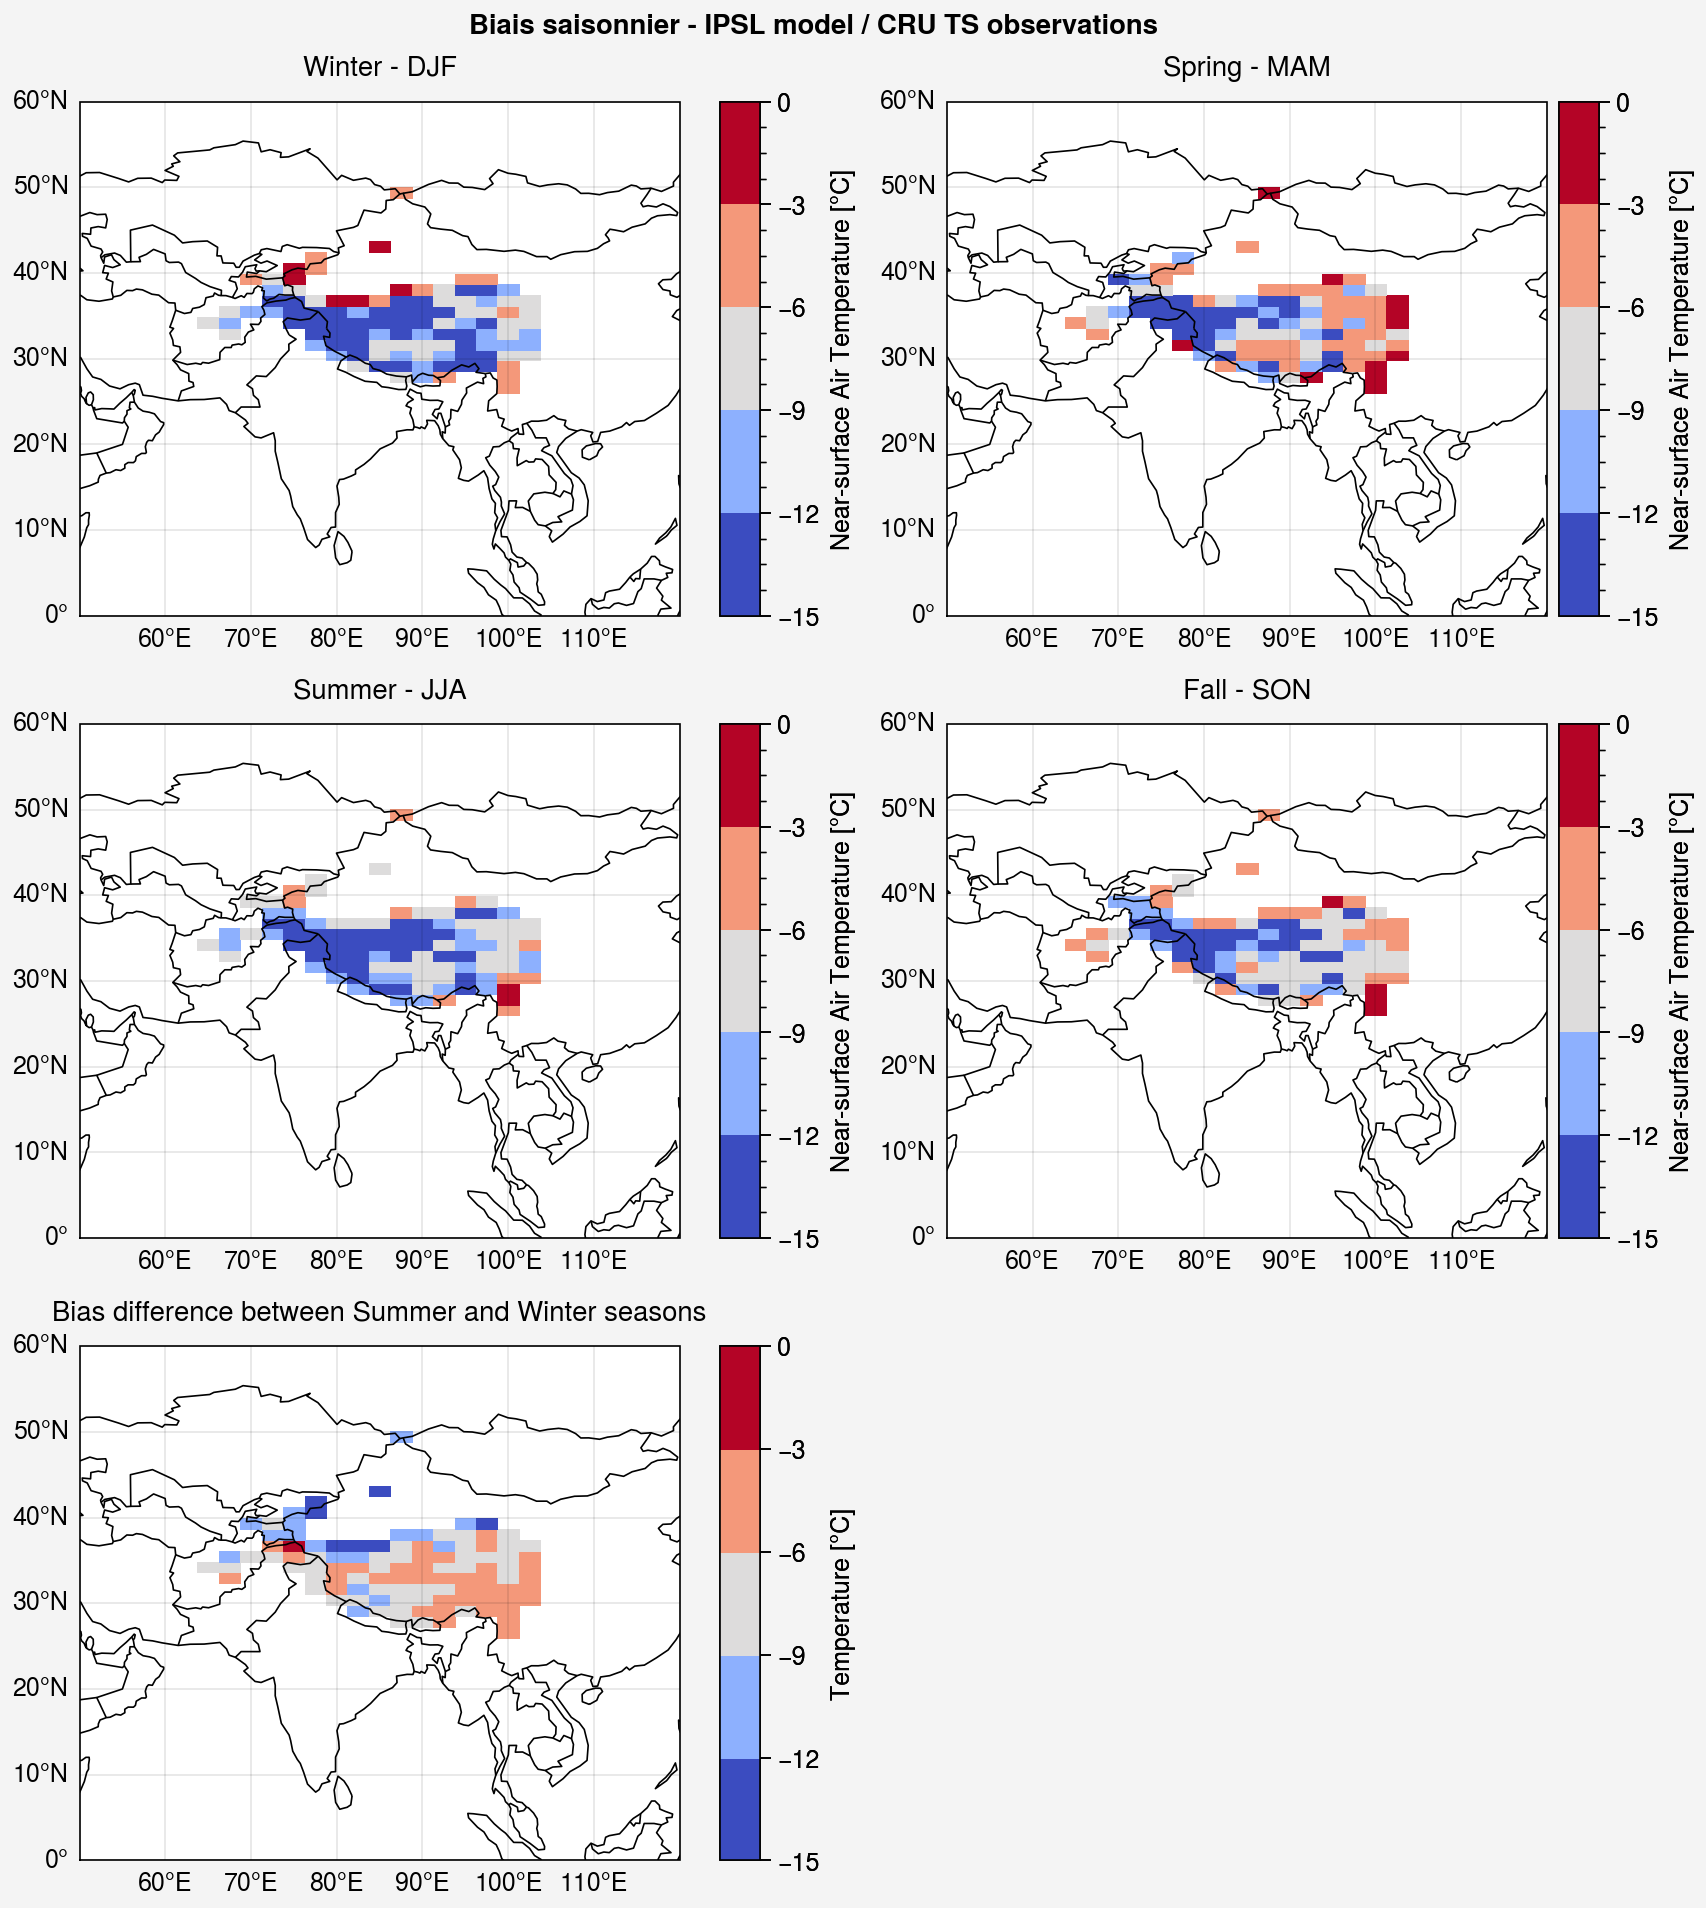

In [5]:

###ouverture membre r1i1p1f1 LR et observations

ds_obs = xr.open_dataset("data/cru_ts/cru_ts4.04.1901.2019.tmp.dat.nc")
tas = xr.open_dataarray('data/tas_1950_2014_r1p1i1f1')

clim = tas.isel(member_id=0).mean('time') - 273.15  
clim_obs = ds_obs.tmp.sel(lon=lonlim, lat=latlim, time=slice('1950','2014')).mean('time')

## on charge le dataset contenant les donéées de topographie

topographie_HMA = xr.open_dataset("data/topographie/GMTED2010_15n240_1000deg_latlon_scipy.nc")

## on crée un regridder de topographie_HMA vers les données du modele

topo_regridder = xe.Regridder(topographie_HMA, clim, method='bilinear', reuse_weights=True, periodic=False)
topographie_HMA_regridded = topo_regridder(topographie_HMA)

# on regrid les observations à la taille du modèle

regridder = xe.Regridder(clim_obs, clim, method='bilinear', reuse_weights=True, periodic=False)
clim_obs_regrid = regridder(clim_obs)

#on sélectionne la zone de plus de 2500m d'altitude pour le modèle et les observations puis on plot le biais

clim_topo = clim.where(topographie_HMA_regridded.elevation > 2500)
clim_obs_regrid_topo = clim_obs_regrid.where(topographie_HMA_regridded.elevation > 2500)
biais_topo = clim_topo - clim_obs_regrid_topo

#biais_topo.plot.contourf()

####on analyse ici la saisonnalité du biais

clim_season = tas.isel(member_id=0).groupby('time.season').mean('time') - 273.15   #on regroupe les climatologies par 4 saison
clim_obs_season = ds_obs.tmp.sel(lon=lonlim, lat=latlim, time=slice('1950','2014')).groupby('time.season').mean('time')


season_regridder = xe.Regridder( clim,clim_season, method='bilinear', reuse_weights=True, periodic=False)

#on regrid le modèle vers les observations saisonnières
clim_season = season_regridder(clim_season)
clim_obs_season = regridder(clim_obs_season)

# on sélectionne la zone au dessus de 2500m d'altitude

clim_season_topo = clim_season.where(topographie_HMA_regridded.elevation > 2500)
clim_obs_season_topo = clim_obs_season.where(topographie_HMA_regridded.elevation > 2500)
biais_season_topo = clim_season_topo - clim_obs_season_topo

#on trace le biais pour les 5 saisons et une comparaison été-hiver

biais_summer = biais_season_topo[2]
biais_winter = biais_season_topo[0]

fig, axs = plot.subplots(nrows=3, ncols=2, proj='cyl', axwidth=3)

levels = plot.arange(-15,0,3)
level_bias_comparison = plot.arange(-5,5,2)
cmap = 'CoolWarm'

m = axs[0].pcolormesh(biais_season_topo[0], cmap=cmap, levels=levels)
axs[0].format(title='Winter - DJF')

axs[1].pcolormesh(biais_season_topo[1], cmap=cmap, levels=levels)
axs[1].format(title='Spring - MAM')

axs[2].pcolormesh(biais_season_topo[2], cmap=cmap, levels=levels)
axs[2].format(title='Summer - JJA')

axs[3].pcolormesh(biais_season_topo[3], cmap=cmap, levels=levels)
axs[3].format(title='Fall - SON')

axs[4].pcolormesh(biais_season_topo[2] - biais_season_topo[0] , cmap=cmap, levels=level_bias_comparison)
axs[4].format(title='Bias difference between Summer and Winter seasons')  ###à enlever ? peu intéressant

axs[0].colorbar(m, label='Near-surface Air Temperature [°C]')
axs[1].colorbar(m, label='Near-surface Air Temperature [°C]')
axs[2].colorbar(m, label='Near-surface Air Temperature [°C]')
axs[3].colorbar(m, label='Near-surface Air Temperature [°C]')
axs[4].colorbar(m, label='Temperature [°C]')

fig.delaxes(axs[5])

axs.format(
    borders=True, coast=True, labels=True,
    lonlim=(lonlim.start, lonlim.stop), latlim=(latlim.start, latlim.stop),
    suptitle='Biais saisonnier - IPSL model / CRU TS observations'
)
fig.savefig('figures/melvil/analyse_saisonnière_biais')


# Le biais est-il présent dans tout l'hémisphère nord ?

Reuse existing file: bilinear_180x720_72x144.nc


/home/melvil/miniconda3/envs/work/lib/python3.7/site-packages/xesmf/frontend.py:345: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  temp_horiz_dims[1]: self.shape_out[1]
/home/melvil/miniconda3/envs/work/lib/python3.7/site-packages/ipykernel_launcher.py:25: ProplotWarning: Got conflicting figure size arguments figwidth=25 and refwidth=3. Ignoring 'refwidth'.
/home/melvil/miniconda3/envs/work/lib/python3.7/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/melvil/miniconda3/envs/work/lib/python3.7/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `g

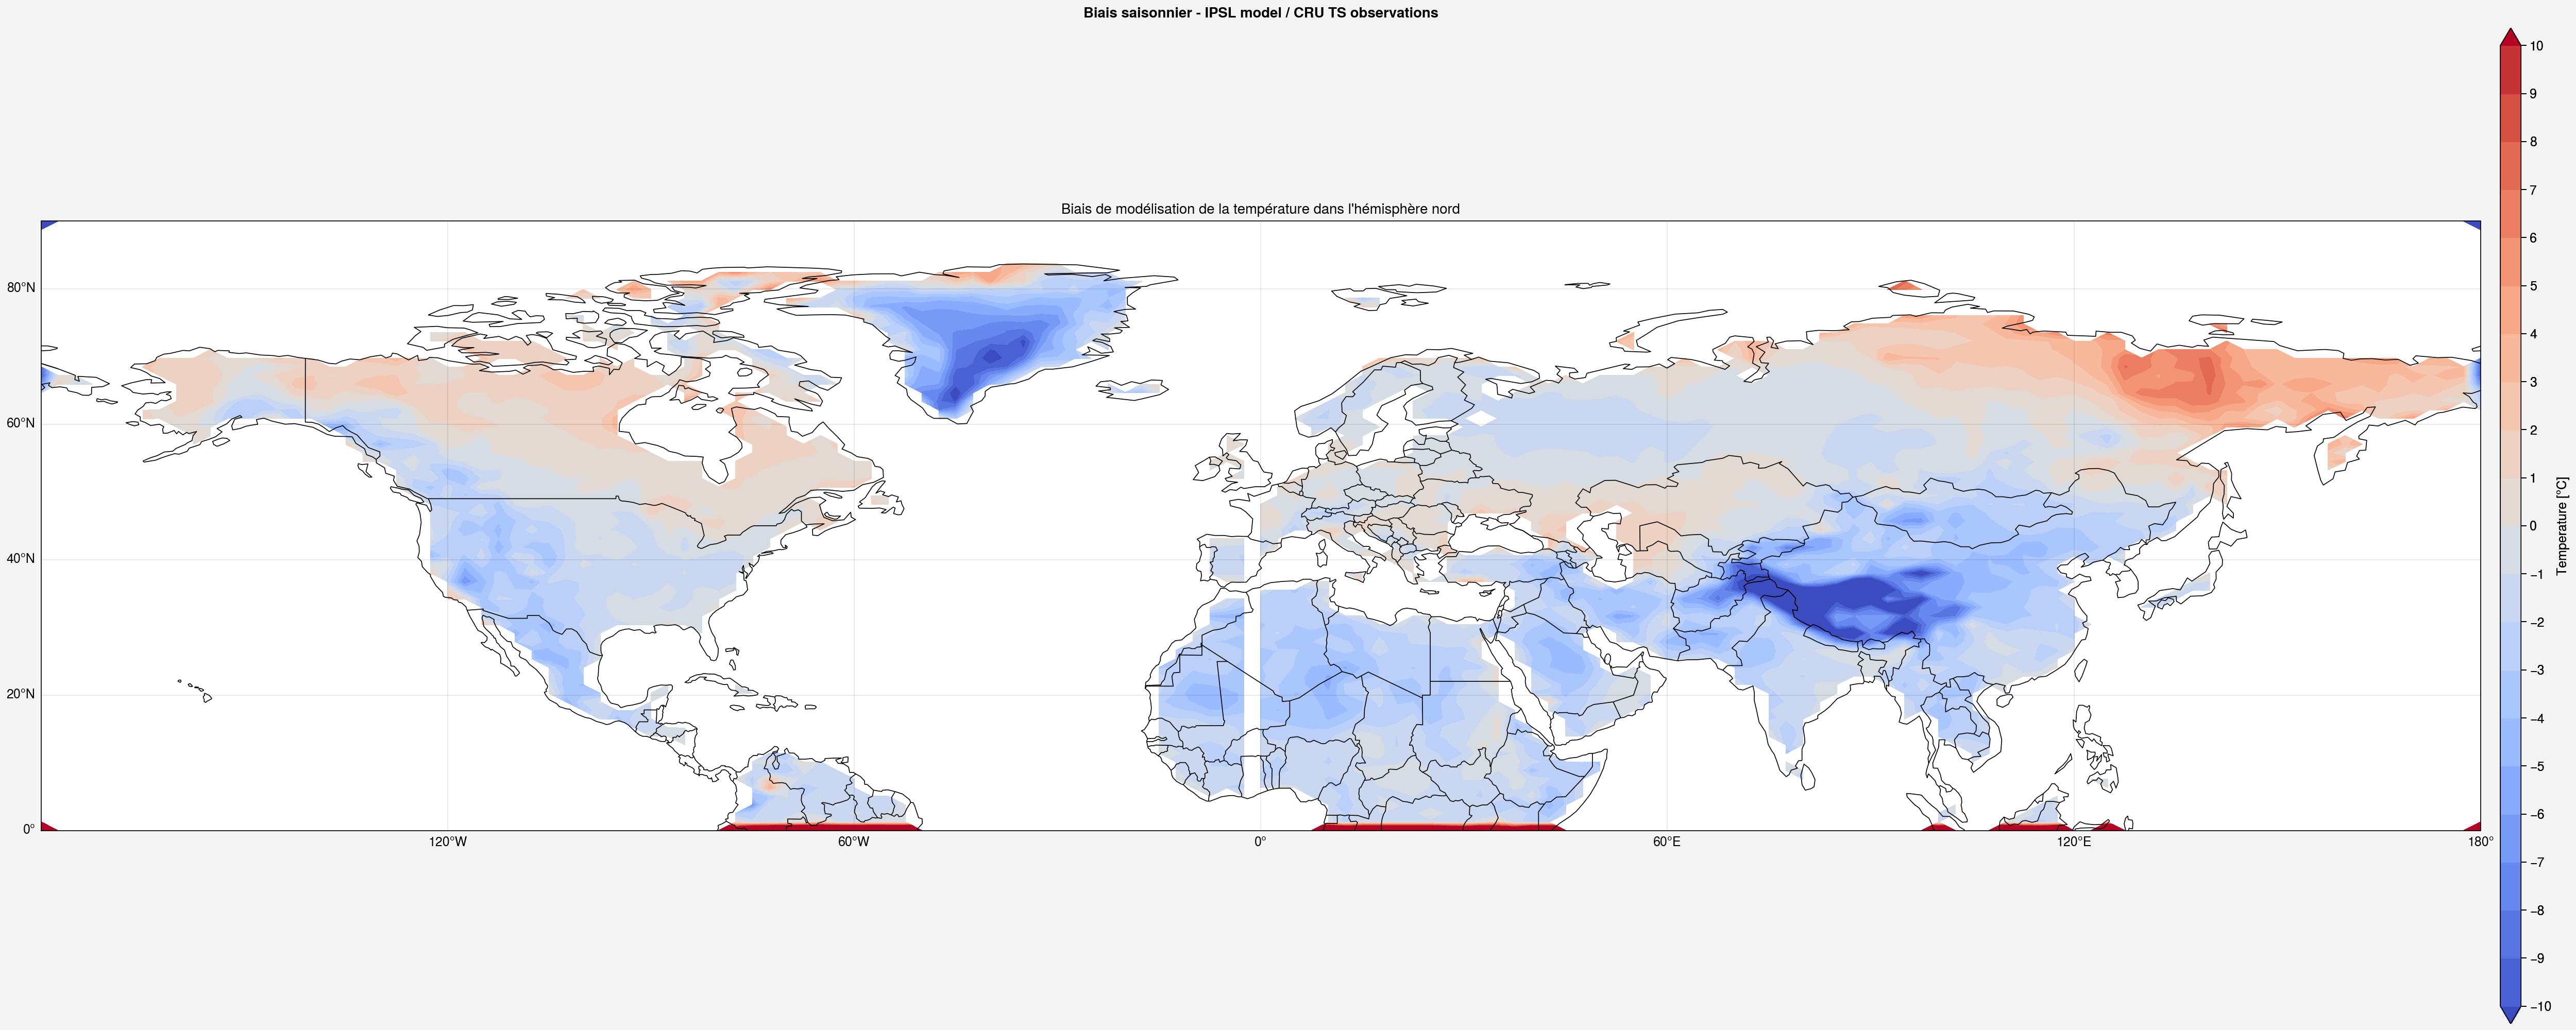

In [6]:
###membre r1i1p1f1
#on définit la zone de l'hémisphère nord

hemisphere_nord = slice(0,90) 

#on sélectionne la zone dans les observations ainsi que dans le modèle 
clim_obs_hemisphere_nord = ds_obs.tmp.sel( lat=hemisphere_nord, time=slice('1950','2014')).mean('time')
tas = xr.open_dataarray('data/hemisphere_nord_1950_2014_r1i1p1f1')
clim_hemisphere_nord = tas.isel(member_id=0, lat=hemisphere_nord).mean('time') - 273.15

#on regrid les observations vers le modèle

hemisphere_nord_regridder =xe.Regridder( clim_obs_hemisphere_nord,clim_hemisphere_nord, method='bilinear', reuse_weights=True, periodic=False)

clim_obs_hemisphere_nord = hemisphere_nord_regridder(clim_obs_hemisphere_nord)

# on calcule le biais dans l'hémisphère nord
biais_hemisphere_nord = clim_hemisphere_nord - clim_obs_hemisphere_nord

#on charge les données pour faciliter le tracé après
biais_hemisphere_nord.load()

# on trace le biais sur une carte de l'hémisphère nord

fig, axs = plot.subplots(ncols=1, proj='cyl', axwidth=3, figsize=(25,10))

levels = plot.arange(-10,10,1)
cmap = 'CoolWarm'

m = axs[0].contourf(biais_hemisphere_nord, cmap=cmap, levels=levels, extend='both')
axs[0].format(title="Biais de modélisation de la température dans l'hémisphère nord")

axs[0].colorbar(m, label='Temperature [°C]')
axs.format(
    borders=True, coast=True, labels=True,
    latlim=(hemisphere_nord.start, hemisphere_nord.stop),
    suptitle='Biais saisonnier - IPSL model / CRU TS observations'
)

fig.savefig('figures/melvil/biais_hemisphere_nord')

# Quel est le lien entre biais de couverture de neige et biais de température ?

Reuse existing file: bilinear_88x88_48x29.nc


/home/melvil/miniconda3/envs/work/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/melvil/miniconda3/envs/work/lib/python3.7/site-packages/xesmf/frontend.py:345: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  temp_horiz_dims[1]: self.shape_out[1]
/home/melvil/miniconda3/envs/work/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:842: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/home/melvil/miniconda3/envs/work/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:848: ShapelyDeprecationWarning: __getitem__ for multi-part geom

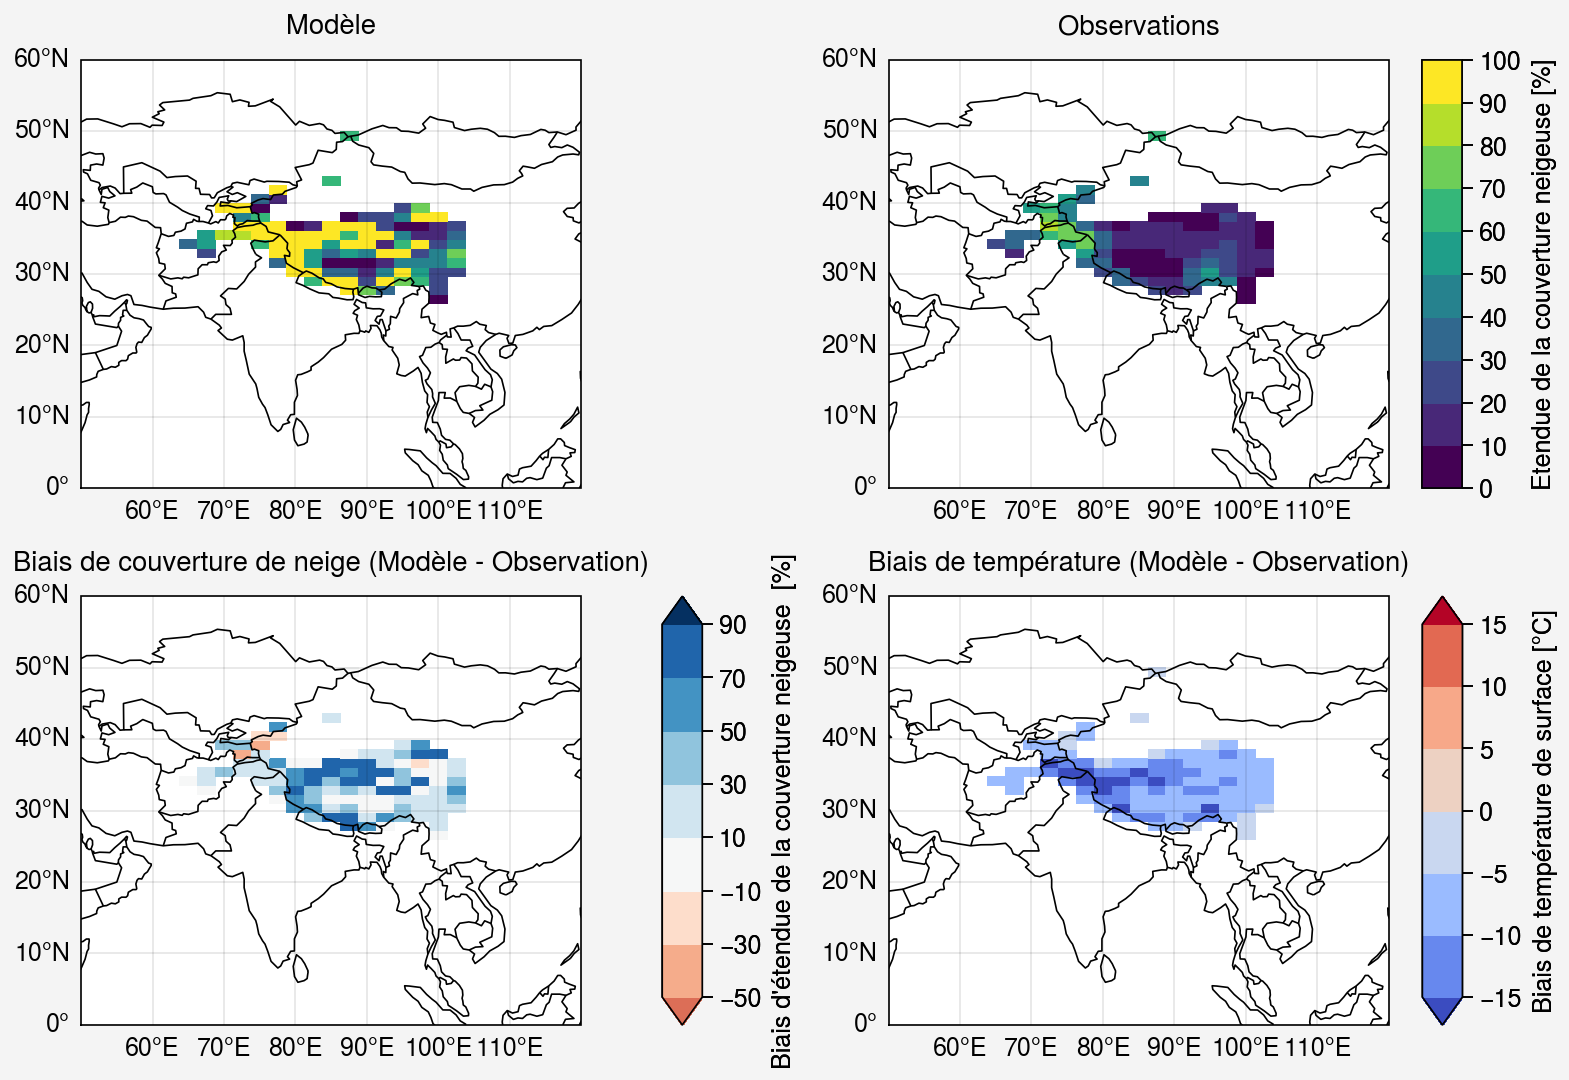

In [22]:
## on ouvre le fichier d'observations contenant la couverture neigeuse

snow_ds_obs = xr.open_dataset('data/NOAA_CDR_NH_SCE/nhsce_v01r01_19661004_20201005.nc')
snc = xr.open_dataarray('data/snow_1950_2014_r1i1p1f1')

## on réucpère la neige dans le fichier d'observations

obs_name = 'NH_SCE_CDR'

# Get the snc variable, keep only land data and convert to %
with xr.set_options(keep_attrs=True):
    snow_obs = snow_ds_obs.snow_cover_extent.where(
        snow_ds_obs.land == 1) * 100
snow_obs.attrs['units'] = '%'
snow_obs.attrs['obs_name'] = obs_name
snow_obs.attrs.update(snow_ds_obs.attrs)

# Rename lon and lat for the regrid
snow_obs = snow_obs.rename({'longitude': 'lon', 'latitude': 'lat'})

# Resamble data per month (from per week)
snow_obs = snow_obs \
    .resample(time='1MS') \
    .mean('time', skipna='False', keep_attrs=True)


## on trace les deux biais spatialement

# Make the regridder
regridder = xe.Regridder(snow_obs, snc, 'bilinear', periodic=False, reuse_weights=True)

# Add NaN instead of 0 for non domain points
regridder = add_matrix_NaNs(regridder)

# Make the regrid
snow_obs_regrid = regridder(snow_obs)

# selection de la période d'intérêt et moyenne temporelle

snow_obs_clim = snow_obs_regrid.sel(time=slice('1950','2014')).mean('time')
snow_model_clim = snc.isel(member_id=0).mean('time')

# sélection de la zone >2500m d'altitude

snow_model_clim_topo = snow_model_clim.where(topographie_HMA_regridded.elevation > 2500)
snow_obs_clim_topo = snow_obs_clim.where(topographie_HMA_regridded.elevation > 2500)

#calcul du biais

biais_snow_topo_regridded = snow_model_clim_topo - snow_obs_clim_topo

#tracé des biais de neige et de température 

lonlim = slice(50,120)
latlim = slice(0,60)

cmap_snc = 'viridis'
levels_snc = plot.arange(0,100,10)
extend_snc = 'neither'

cmap_bias = 'RdBu'
levels_bias = plot.arange(-50,100,20)
extend_bias = 'both'

cmap_temp_bias  = 'CoolWarm'
levels_temp_bias = plot.arange(-15, 15, 5)


fig, axs = plot.subplots(ncols=2, nrows=2, proj='cyl')

m = axs[0].pcolormesh(snow_model_clim_topo.sel(lat=latlim, lon=lonlim), cmap=cmap_snc, levels=levels_snc, extend=extend_snc)
axs[0].format(title='Modèle')

axs[1].pcolormesh(snow_obs_clim_topo.sel(lat=latlim, lon=lonlim), cmap=cmap_snc, levels=levels_snc, extend=extend_snc)
axs[1].format(title='Observations')
axs[1].colorbar(m, label='Etendue de la couverture neigeuse [%]')

m = axs[2].pcolormesh(biais_snow_topo_regridded.sel(lat=latlim, lon=lonlim), cmap=cmap_bias, levels=levels_bias, extend=extend_bias)
axs[2].format(title='Biais de couverture de neige (Modèle - Observation)')
axs[2].colorbar(m, label="Biais d'étendue de la couverture neigeuse  [%]")

m = axs[3].pcolormesh(biais_topo, cmap=cmap_temp_bias, levels=levels_temp_bias, extend=extend_bias)
axs[3].format(title='Biais de température (Modèle - Observation)')
axs[3].colorbar(m, label='Biais de température de surface [°C]')

axs.format(
    coast=True, borders=True, labels=True,
    suptitle='',
    lonlim=(lonlim.start,lonlim.stop),
    latlim=(latlim.start,latlim.stop)
)
fig.savefig('figures/melvil/analyse_biais_neige_temp')

## correlation spatiale

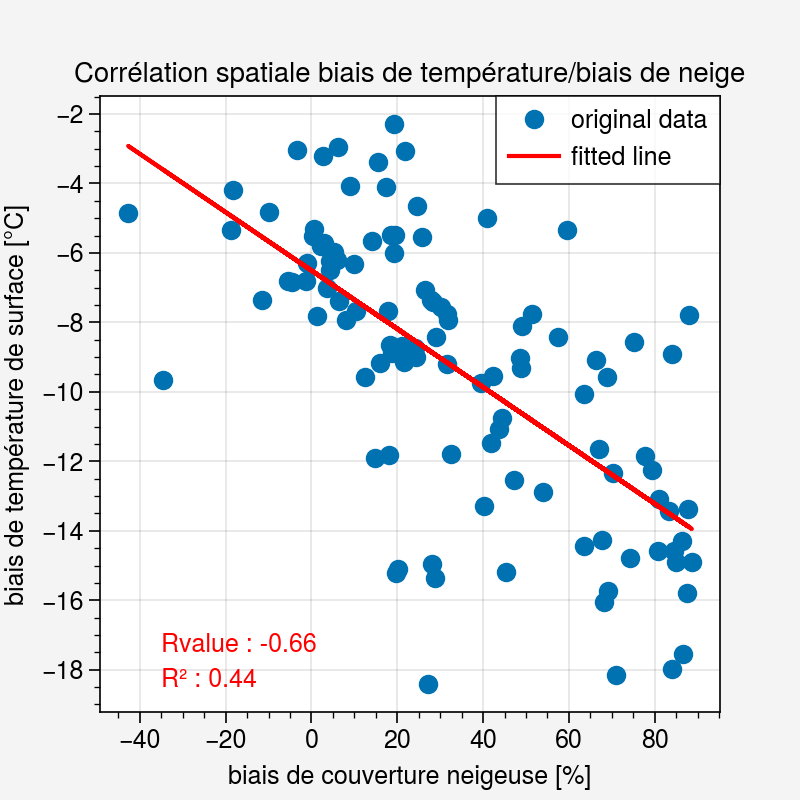

In [23]:
# on crée des dataframes contenant les valeurs de couverture de neige et de température

snow_for_correlation_df = snow_model_clim_topo.to_dataframe().dropna(how='any')
temp_for_correlation_df = clim_topo.to_dataframe().dropna(how='any')
snow_obs_for_correlation_df = snow_obs_clim_topo.to_dataframe().dropna(how='any')
temp_obs_for_correlation_df = clim_obs_regrid_topo.to_dataframe().dropna(how='any')

# on renomme les colonnes dans les observations

snow_obs_for_correlation_df = snow_obs_for_correlation_df.rename(columns={"snow_cover_extent": "snc",})
temp_obs_for_correlation_df = temp_obs_for_correlation_df.rename(columns={"tmp": "tas",})

# on calcule les biais

biais_snow_for_correlation_df = snow_for_correlation_df.subtract(snow_obs_for_correlation_df, axis='columns', level='snc', fill_value=None)
biais_temp_for_correlation_df = temp_for_correlation_df.subtract(temp_obs_for_correlation_df, axis='columns', level='tas', fill_value=None)

# on étudie la corrélation biais de couverture neigeuse/biais de température

x = biais_snow_for_correlation_df['snc']
y1 = biais_temp_for_correlation_df['tas']
res = stats.linregress(x,y1)
y2 = (x*res.slope + res.intercept)

plt.plot(x, y1, 'o', label='original data')

plt.plot(x, y2, 'r', label='fitted line')

plt.xlabel('biais de couverture neigeuse [%]')
plt.ylabel('biais de température de surface [°C]')
plt.title('Corrélation spatiale biais de température/biais de neige')
plt.text(-35, -17.5, 'Rvalue : ' + str('{:.2f}'.format(res.rvalue)), color = 'red')
plt.text(-35, -18.5, 'R² : ' + str('{:.2f}'.format((res.rvalue)*res.rvalue)), color = 'red')

plt.legend()
plt.savefig('figures/melvil/correlation_neige_temp')
plt.show()




# comparaison des biais LR et HR

Reuse existing file: bilinear_180x360_120x140.nc
using dimensions ('lat', 'lon') from data variable elevation as the horizontal dimensions for this dataset.


/home/melvil/miniconda3/envs/work/lib/python3.7/site-packages/xesmf/frontend.py:391: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  temp_horiz_dims[1]: self.shape_out[1]


Reuse existing file: bilinear_120x140_121x99.nc
Reuse existing file: bilinear_180x360_121x99.nc
using dimensions ('lat', 'lon') from data variable elevation as the horizontal dimensions for this dataset.


/home/melvil/miniconda3/envs/work/lib/python3.7/site-packages/xesmf/frontend.py:345: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  temp_horiz_dims[1]: self.shape_out[1]
/home/melvil/miniconda3/envs/work/lib/python3.7/site-packages/xesmf/frontend.py:391: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  temp_horiz_dims[1]: self.shape_out[1]


<xarray.DataArray ()>
array(0.24619941, dtype=float32)
Coordinates:
    height   float64 2.0 <xarray.DataArray ()>
array(0.49263075, dtype=float32)
Coordinates:
    height   float64 2.0


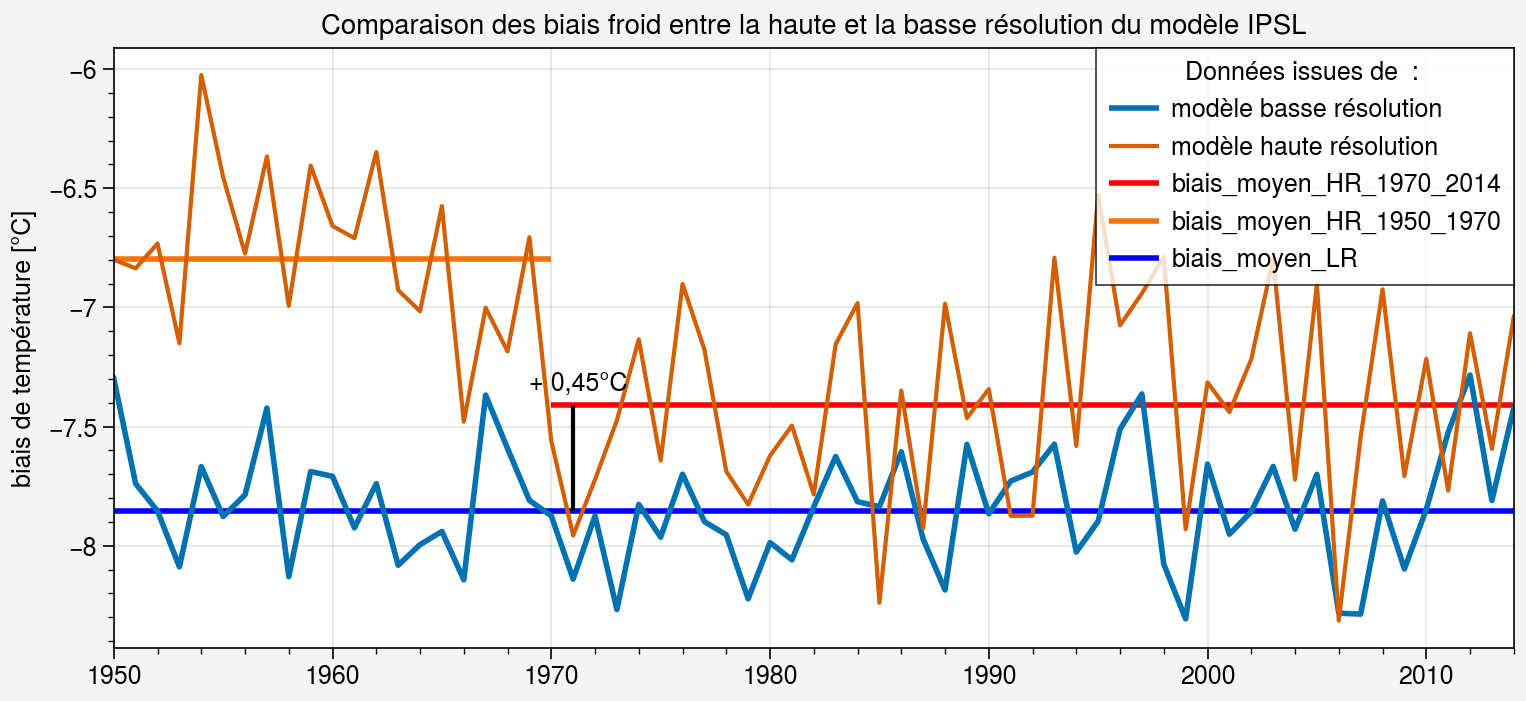

In [24]:
# on récupère des variables utiles pour la suite

#ds_obs = xr.open_dataset('data/cru_ts/cru_ts4.04.1901.2019.tmp.dat.nc')
clim_obs = ds_obs.tmp.sel(lon=lonlim, lat=latlim, time=slice('1950','2014')).mean('time')




obs_for_trend = ds_obs.tmp.sel(lon=lonlim, lat=latlim, time=slice('1950','2014'))

regridder_obs = xe.Regridder(topographie_HMA, obs_for_trend, method='bilinear', reuse_weights=True, periodic=False)
topographie_HMA_obs = regridder_obs(topographie_HMA)

obs_for_trend = obs_for_trend.where(topographie_HMA_obs.elevation > 2500)

weights_obs = np.cos(np.deg2rad(obs_for_trend.lat))
weights_obs.name = "weights_obs"

obs_for_trend =obs_for_trend.resample(time="Y").mean(skipna = True).mean('lon', skipna=True ).weighted(weights_obs).mean('lat',skipna = True) 

tas = xr.open_dataarray('data/1950_2014_32members_for_trend')  
tas = tas.where(topographie_HMA_regridded.elevation > 2500)

weights = np.cos(np.deg2rad(tas.lat))
weights.name = "weights"


model_past_trend = tas.resample(time="Y").mean(skipna =True).mean(('member_id', 'lon'), skipna =True).weighted(weights).mean('lat', skipna = True) - 273.15


## on ouvre les données de température du modèle pour un membre

tas = xr.open_dataarray('data/HR_tas_1950_2014')


# on moyenne sur le temps

clim_HR = tas.mean('time')

# on regrid les observations vers la résolution du modèle

regridder_HR = xe.Regridder(clim_obs, clim_HR, method='bilinear', reuse_weights=True, periodic=False)
clim_obs = regridder_HR(clim_obs)


regridder_topo_HR = xe.Regridder(topographie_HMA, clim_HR, method='bilinear', reuse_weights=True, periodic=False)

topographie_HMA_HR = regridder_topo_HR(topographie_HMA)


# on calcule le biais au dessus de 2500m d'altitude

weights_HR = np.cos(np.deg2rad(tas.lat))
weights_HR.name = "weights_HR"

biais_HR_for_comparison_with_biais = tas.where(topographie_HMA_HR.elevation > 2500).resample(time = 'Y').mean().mean('member_id').mean('lon').weighted(weights_HR).mean('lat') - 273.15 - obs_for_trend
#biais_HR_for_comparison_with_biais.plot()

# on calcule le biais temporel pour le modèle LR (au dessus de 2500m d'altitude)

biais_temporel_LR = model_past_trend - obs_for_trend

#on plot les biais HR et LR pour les comparer

mean_HR = biais_HR_for_comparison_with_biais.sel(time=slice('1970','2014')).mean('time')
mean_HR_past = biais_HR_for_comparison_with_biais.sel(time=slice('1950','1970')).mean('time')
mean_LR = biais_temporel_LR.sel(time=slice('1970','2014')).mean('time')
year_1950_2014 = np.arange(1950,2015,1)
year_2015_2100 = np.arange(2015,2101,1)

fig, axs = plot.subplots(nrows=1, ncols=1, axwidth=7, axheight = 3, xmin=1950, xmax=2014)  

axs[0,0].plot(year_1950_2014, biais_temporel_LR, lw=2, labels='modèle basse résolution')
axs[0,0].plot(year_1950_2014, biais_HR_for_comparison_with_biais, labels='modèle haute résolution')
axs[0,0].hlines(mean_HR ,1970, 2014, linewidth=2, color='red', linestyles='solid', label='biais_moyen_HR_1970_2014')
axs[0,0].hlines(mean_HR_past ,1950, 1970, linewidth=2, color='orange', linestyles='solid', label='biais_moyen_HR_1950_1970')
axs[0,0].hlines(mean_LR ,1950, 2014, linewidth=2, color='blue', linestyles='solid', label='biais_moyen_LR')
axs[0,0].vlines(1971, mean_LR, mean_HR, color='black')
axs[0,0].text(1969, -7.35, "+ 0,45°C", color = 'black')



axs[0, 0].format(title='Comparaison des biais froid entre la haute et la basse résolution du modèle IPSL', ylabel='biais de température [°C]')
axs[0,0].legend(loc='ur', ncols=1, label='Données issues de  : ')

fig.savefig('figures/melvil/Biais_comparison_LR_HR')

LR_var = biais_temporel_LR.std()
LR_var
HR_var = biais_HR_for_comparison_with_biais.std()
print(LR_var, HR_var)